In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [8]:
# Load the dataset
url = "loan_prediction.csv"
df = pd.read_csv(url)

# Assign correct column names
df.columns = ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 
              'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 
              'Credit_History', 'Property_Area', 'Loan_Status']

### Exploratory Data Analysis

In [9]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            613 non-null    object 
 1   Gender             600 non-null    object 
 2   Married            610 non-null    object 
 3   Dependents         598 non-null    object 
 4   Education          613 non-null    object 
 5   Self_Employed      581 non-null    object 
 6   ApplicantIncome    613 non-null    int64  
 7   CoapplicantIncome  613 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   599 non-null    float64
 10  Credit_History     563 non-null    float64
 11  Property_Area      613 non-null    object 
 12  Loan_Status        613 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.4+ KB


### Summary statistics for numerical columns

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,613.0,5402.732463,6114.004114,150.0,2876.0,3812.0,5780.0,81000.0
CoapplicantIncome,613.0,1623.890571,2927.903583,0.0,0.0,1210.0,2302.0,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.0,700.0
Loan_Amount_Term,599.0,341.969950,65.170672,12.0,360.0,360.0,360.0,480.0
Credit_History,563.0,0.841918,0.365142,0.0,1.0,1.0,1.0,1.0


#### Check for missing values

In [12]:
print(df.isnull().sum())

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           21
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


#### Column with missing values

* Gender = 13
* Married = 3
* Dependents = 15
* Self_Employed = 32
* LoanAmount = 21
* Loan_Amount_Term = 14
* Credit_History = 50

We Need to fixed this null values before start engineering

## Data preprocessing

In [13]:
# Handle missing values
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df['Married'].fillna(df['Married'].mode()[0], inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)
df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)

# Encode categorical variables
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])
df['Married'] = label_encoder.fit_transform(df['Married'])
df['Education'] = label_encoder.fit_transform(df['Education'])
df['Self_Employed'] = label_encoder.fit_transform(df['Self_Employed'])
df['Property_Area'] = label_encoder.fit_transform(df['Property_Area'])
df['Loan_Status'] = label_encoder.fit_transform(df['Loan_Status'])


## Data visualization

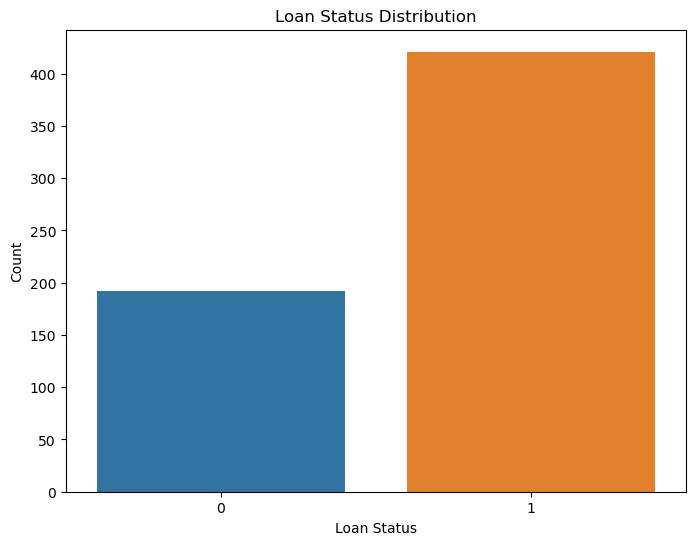

In [14]:
# Distribution of Loan_Status
plt.figure(figsize=(8, 6))
sns.countplot(x='Loan_Status', data=df)
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.show()

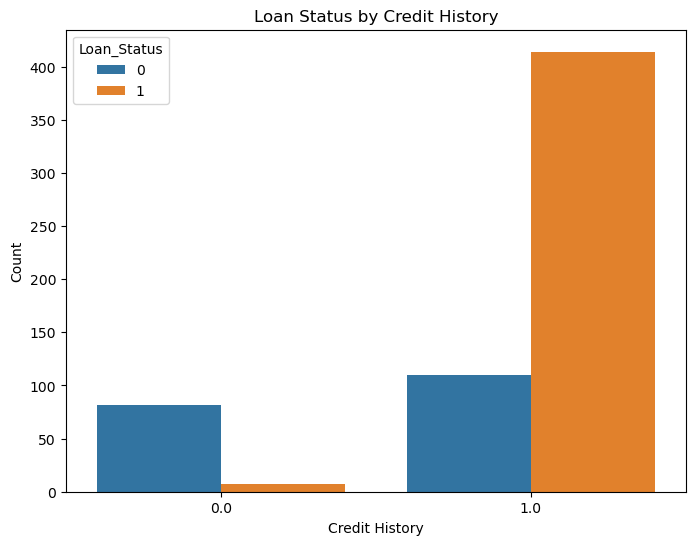

In [15]:
# Relationship between Credit_History and Loan_Status
plt.figure(figsize=(8, 6))
sns.countplot(x='Credit_History', hue='Loan_Status', data=df)
plt.title('Loan Status by Credit History')
plt.xlabel('Credit History')
plt.ylabel('Count')
plt.show()

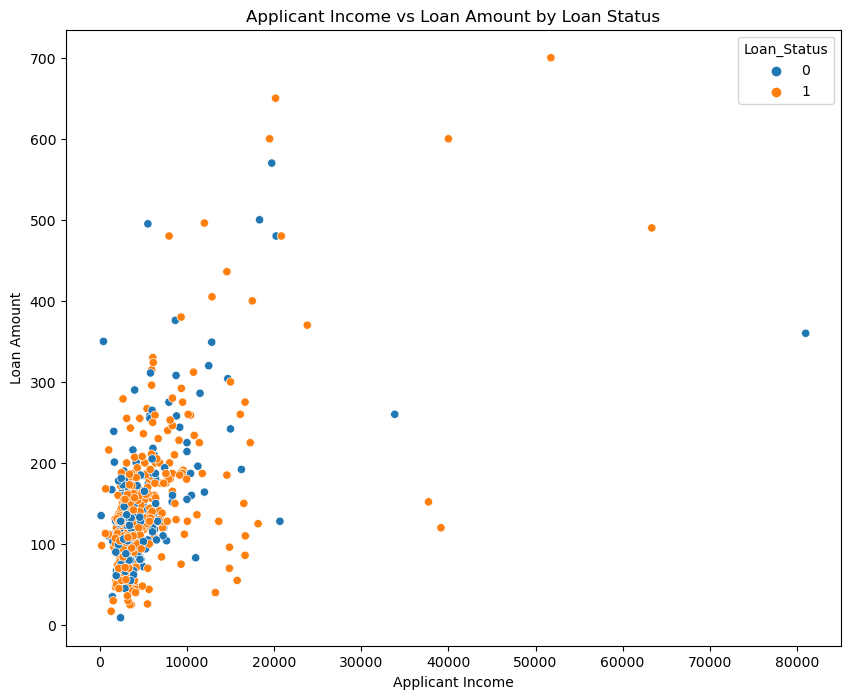

In [16]:
# Relationship between Applicant Income and Loan Amount
plt.figure(figsize=(10, 8))
sns.scatterplot(x='ApplicantIncome', y='LoanAmount', hue='Loan_Status', data=df)
plt.title('Applicant Income vs Loan Amount by Loan Status')
plt.xlabel('Applicant Income')
plt.ylabel('Loan Amount')
plt.show()

## Model building

In [23]:
# Feature selection
X = df.drop(['Loan_ID', 'Loan_Status'], axis=1)
y = df['Loan_Status']

# Splitting dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Models to evaluate
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB()
}

# Function to evaluate models
def evaluate_models(models, X_train, X_test, y_train, y_test):
    for name, model in models.items():
        pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        pipe.fit(X_train, y_train)
        train_score = pipe.score(X_train, y_train)
        test_score = pipe.score(X_test, y_test)
        print(f"{name}:")
        print(f"  Training accuracy: {train_score:.3f}")
        print(f"  Test accuracy: {test_score:.3f}")
        print()

# Evaluate models
evaluate_models(models, X_train, X_test, y_train, y_test)

# Model selection and tuning (Example with Random Forest)
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [None, 5, 10, 15],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters found:")
print(grid_search.best_params_)
print("Best cross-validation score:")
print(grid_search.best_score_)

Logistic Regression:
  Training accuracy: 0.812
  Test accuracy: 0.813

Random Forest:
  Training accuracy: 1.000
  Test accuracy: 0.780

Support Vector Machine:
  Training accuracy: 0.824
  Test accuracy: 0.780

K-Nearest Neighbors:
  Training accuracy: 0.827
  Test accuracy: 0.797

Decision Tree:
  Training accuracy: 1.000
  Test accuracy: 0.699

Naive Bayes:
  Training accuracy: 0.810
  Test accuracy: 0.780



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Best parameters found:
{'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Best cross-validation score:
0.8081632653061224


### Model Performance Overview

**Logistic Regression:**

* Training accuracy: 81.2%
* Test accuracy: 81.3%
* Logistic Regression performed well, with a balanced performance on both the training and test sets.

**Random Forest:**

* Training accuracy: 100%
* Test accuracy: 78%
* The Random Forest model exhibited overfitting, as it achieved perfect accuracy on the training set but significantly lower accuracy on the test set.

**Support Vector Machine (SVM):**

* Training accuracy: 82.4%
* Test accuracy: 78%
* The SVM model also performed well, with a slight overfitting indicated by the difference between training and test accuracies.

**K-Nearest Neighbors (KNN):**

* Training accuracy: 82.7%
* Test accuracy: 79.7%
* KNN showed a good balance between training and test performance, indicating a reasonable fit to the data.

**Decision Tree:**

* Training accuracy: 100%
* Test accuracy: 69.9%
* The Decision Tree model overfitted the training data significantly, as seen by the perfect training accuracy and poor test accuracy.

**Naive Bayes:**

* Training accuracy: 81%
* Test accuracy: 78%
* Naive Bayes performed similarly to Logistic Regression and SVM, with consistent performance on both training and test sets.

* Hyperparameter Tuning Results

**Random Forest:**
**Best parameters found:**
* max_depth: 5
* min_samples_leaf: 1
* min_samples_split: 2
* n_estimators: 50
* Best cross-validation score: 80.8%
* The tuned Random Forest model achieved a better cross-validation score compared to the untuned model, indicating improved generalizability.

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.38      0.52        37
           1       0.78      0.97      0.86        86

    accuracy                           0.79       123
   macro avg       0.80      0.67      0.69       123
weighted avg       0.80      0.79      0.76       123



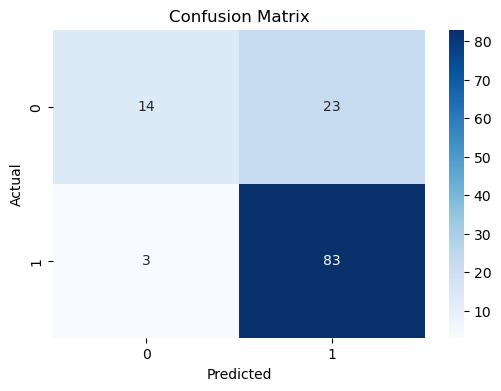

In [24]:
# Final model evaluation
final_model = grid_search.best_estimator_
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

# Classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Final Model Evaluation

**Final Model (Tuned Random Forest):**
**Classification Report:**
* Precision, recall, and f1-score were higher for class '1' (loan approved) compared to class '0' (loan not approved).
* Overall accuracy: 79%
* Macro average (balanced across both classes): Precision (80%), Recall (67%), F1-score (69%)
* Weighted average (considering class distribution): Precision (80%), Recall (79%), F1-score (76%)

**Confusion Matrix:**

* True Negatives (correctly predicted as loan not approved): 14
* False Positives (incorrectly predicted as loan approved): 23
* False Negatives (incorrectly predicted as loan not approved): 3
* True Positives (correctly predicted as loan approved): 83

## Conclusion

**Model Selection:**

* Logistic Regression, SVM, KNN, and Naive Bayes models performed comparably well, with test accuracies around 78-81%.
* The Decision Tree model overfitted the training data and underperformed on the test data.
* The initial Random Forest model also showed overfitting, but after hyperparameter tuning, the Random Forest model provided a more balanced performance.

**Tuned Random Forest Model:**

* The hyperparameter-tuned Random Forest model demonstrated improved generalizability with a cross-validation accuracy of approximately 80.8%.
* The tuned model achieved a test accuracy of 79%, with better performance metrics for predicting loan approvals compared to rejections.

**Performance Metrics:**

* The tuned Random Forest model showed higher precision, recall, and f1-score for predicting loan approvals, which is critical for reducing false positives in a real-world loan approval scenario.
* The model's recall for predicting loan approvals (97%) is particularly important, as it indicates the model's effectiveness in identifying most of the applicants who should be granted loans.